# Machine Learning - Exercise 4
This exercise focuses on application of clustering techniques on the selected dataset from the Kaggle or UCI repository. Students will apply different clustering algorithms, compare their results, and visualize the clustering structure using scatter plots.



* 💡 **Agglomerative clustering** is a **bottom-up approach** to clustering.
    * We first divide **each instance into its own cluster** and **merge them into couples** based on a similarity metric.
    * Subsequently we compute the **similarity** again and **merge the couples into bigger groups** (clusters).
    * These groups are then merged into the bigger ones **till there is only a one big group containing all the instances present at the top**.
    * https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html
* 💡 **K-means** is a **partitioning approach** to clustering.
    * We **first choose the number of clusters K** and **initialize K centroids** (often at random).
    * Repeatedly **assign each point to its nearest centroid** (by a distance like Euclidean).
    * Then **recompute each centroid** as the mean of the points assigned to it.
    * **Iterate assignment** → update until centroids stop moving (or a max number of steps is reached).
    * https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* 💡 **DBSCAN** is a **density-based approach** to clustering.
    * We set **ε (eps) for neighborhood radius** and **min_samples for the minimum points** to form dense regions.
    * **Points with ≥ min_samples** neighbors **within ε are core points,** neighbors of cores are **border points**, others are **noise/outliers**.
    * **Start from a core point and expand** by connecting nearby cores/borders to **grow a cluster**.
    * **Repeat** until all points are visited—yielding clusters of arbitrary shapes and identifying outliers naturally.
    * https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

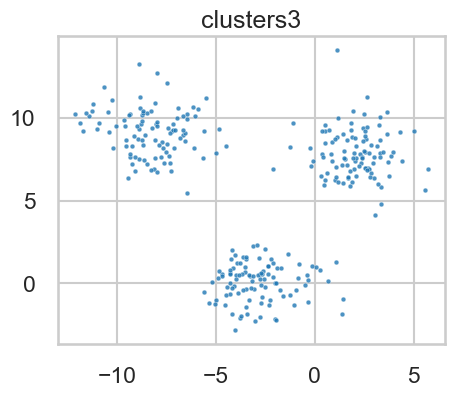

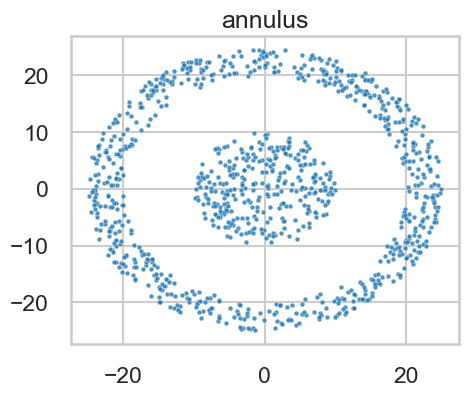

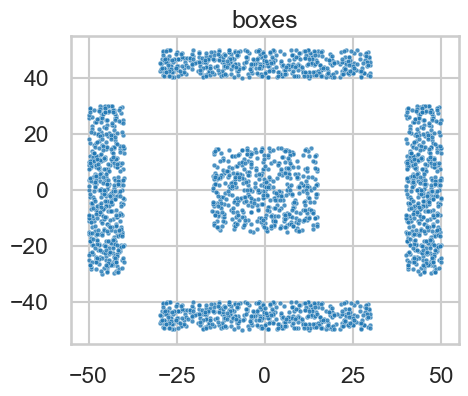

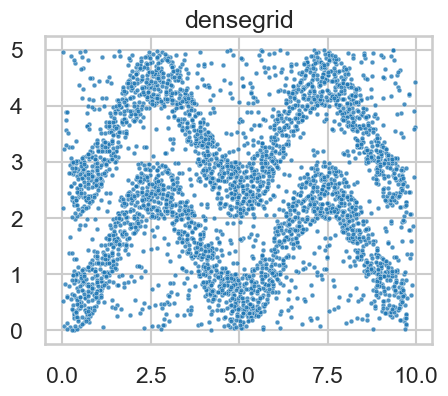

In [11]:
import numpy as np
import pandas as pd
import os
from scipy.spatial import distance_matrix
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', 90)
plt.rcParams['font.family'] = 'Arial'

# Global plot style
sns.set_theme(style='whitegrid', context='talk', palette='tab10')

# Load datasets directly from CSV files in the current folder
datasets = dict()
files = ['clusters3','annulus','boxes','densegrid']
for data_file in files:
    path = f'/Users/stepankudlacek/VSCode/su/datasets/data_clustering/{data_file}.csv'
    if os.path.exists(path):
        try:
            data = np.loadtxt(path, delimiter=';')
        except Exception:
            data = np.loadtxt(path, delimiter=',')
    else:
        # if file not found, skip (assumption: files are in same folder as this notebook)
        print(f'Warning: {path} not found; skipping')
        continue
    datasets[data_file] = data
    plt.figure(figsize=(5,4))
    plt.scatter(data[:, 0], data[:, 1], s=12, alpha=0.8, edgecolors='white', linewidths=0.3)
    plt.title(data_file)
plt.show()

=== clusters3 ===
=== annulus ===


/var/folders/61/z5l932l5167f73mcxrfnwq1c0000gn/T/ipykernel_62231/2396476021.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5.5,4.5))


=== boxes ===
=== densegrid ===


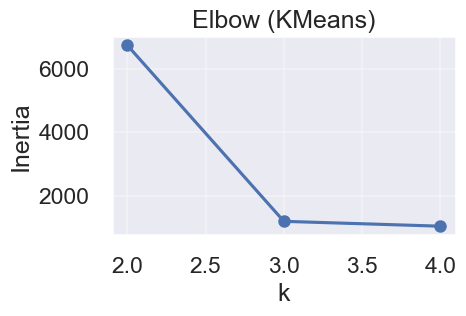

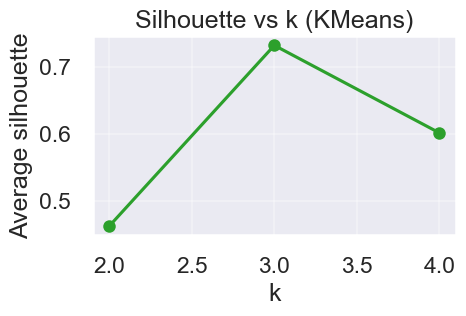

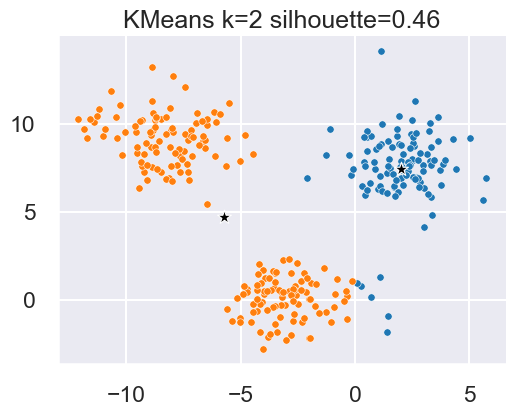

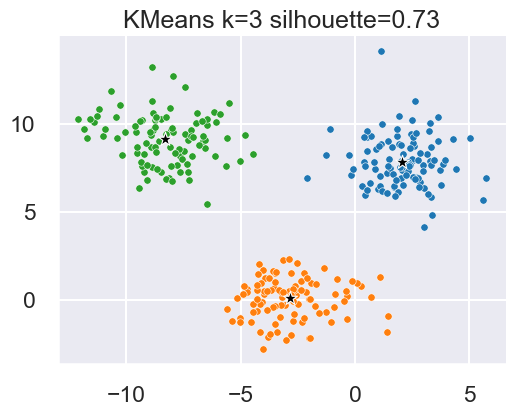

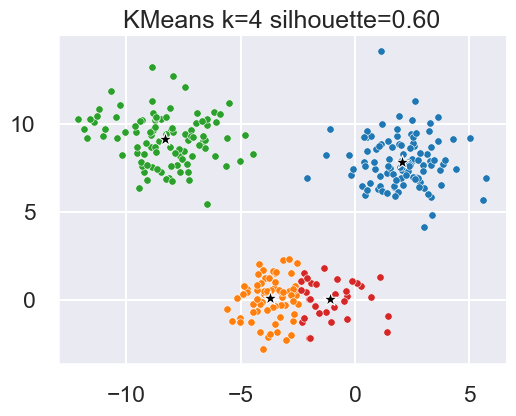

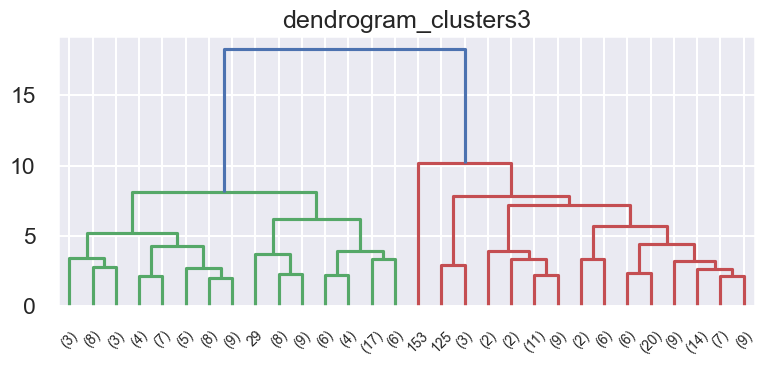

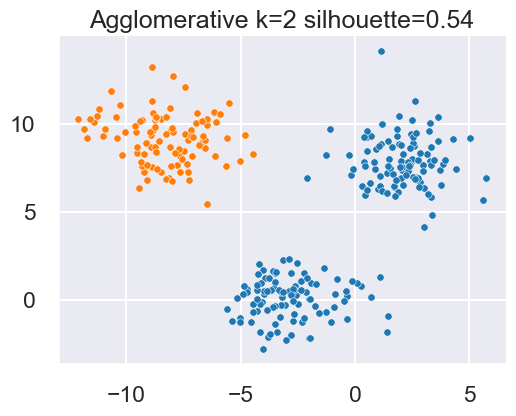

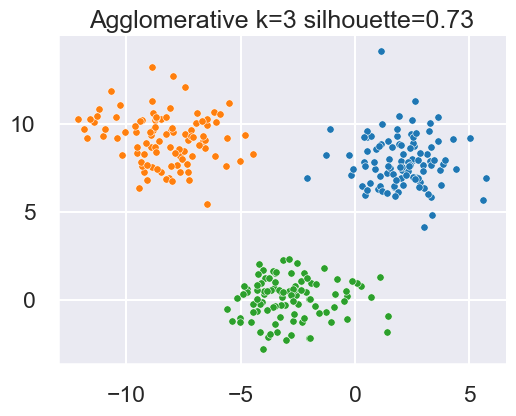

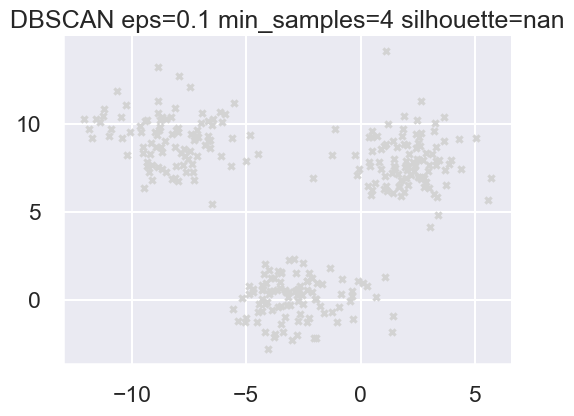

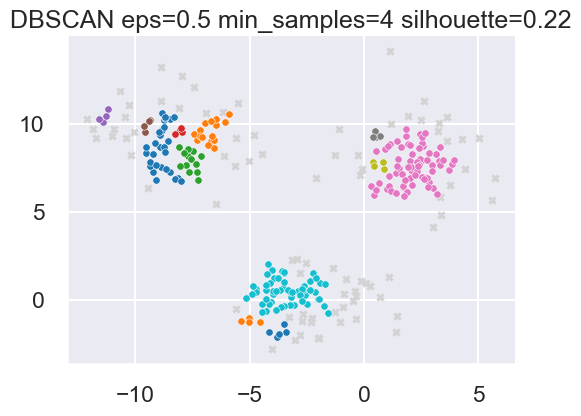

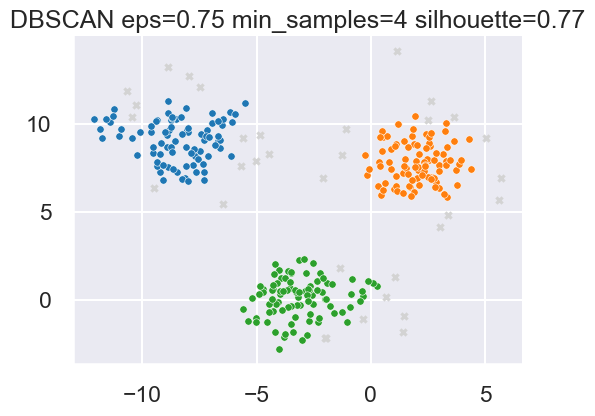

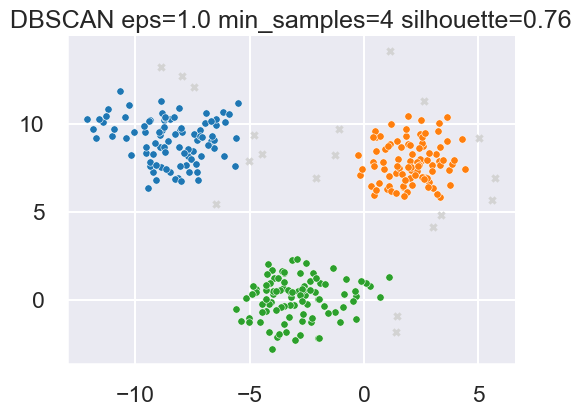

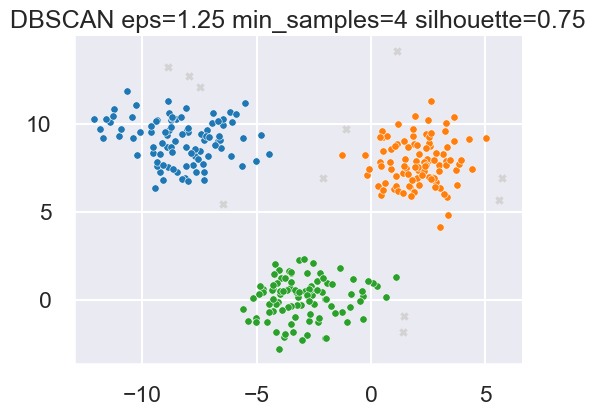

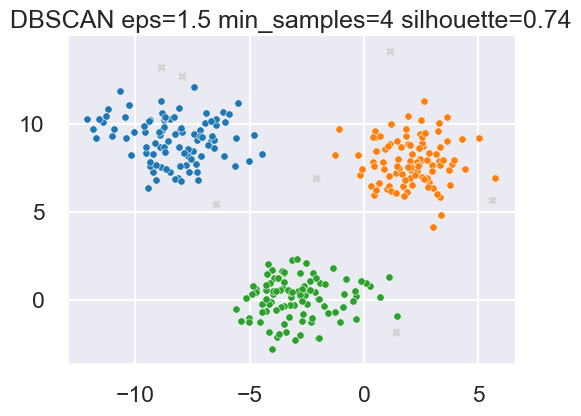

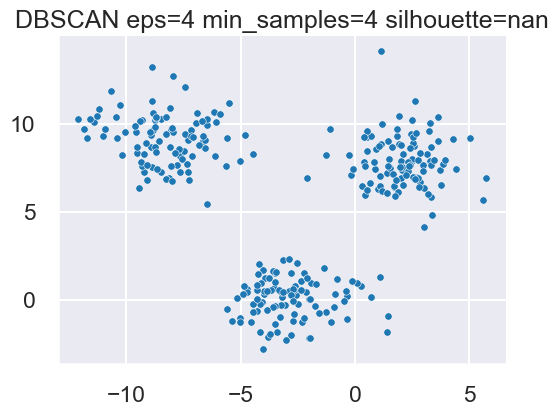

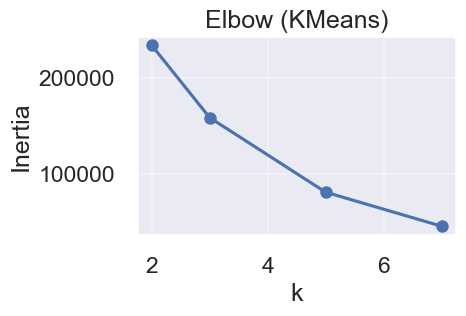

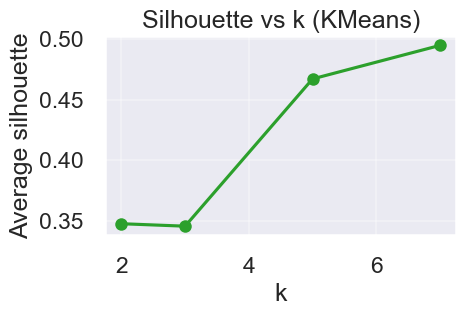

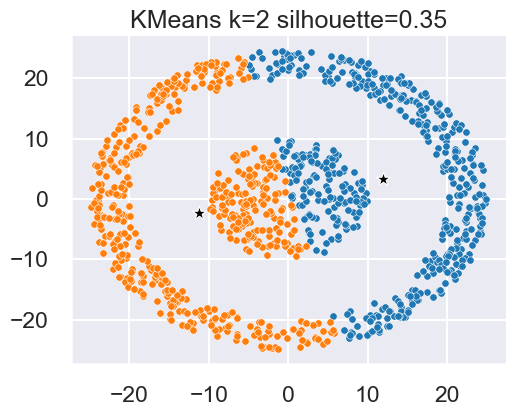

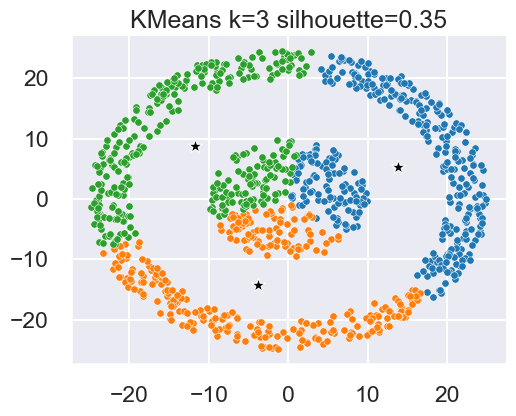

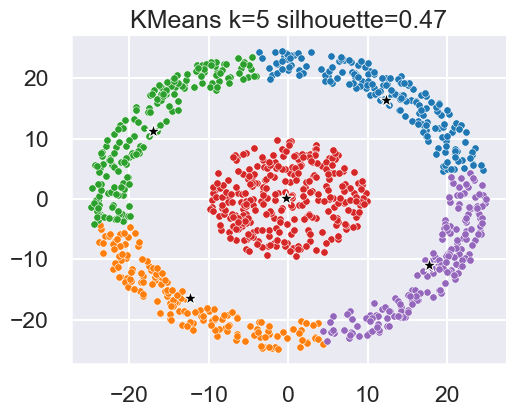

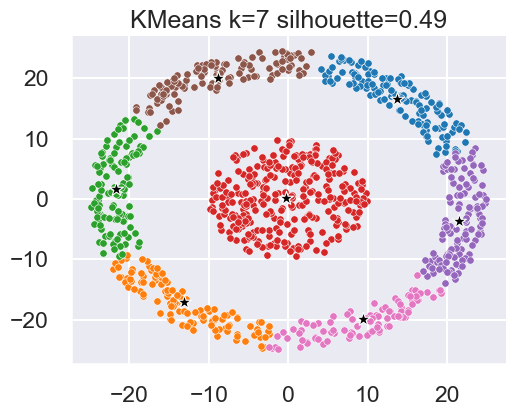

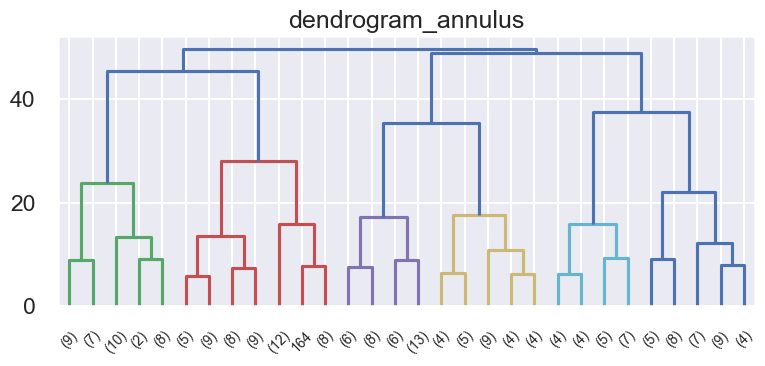

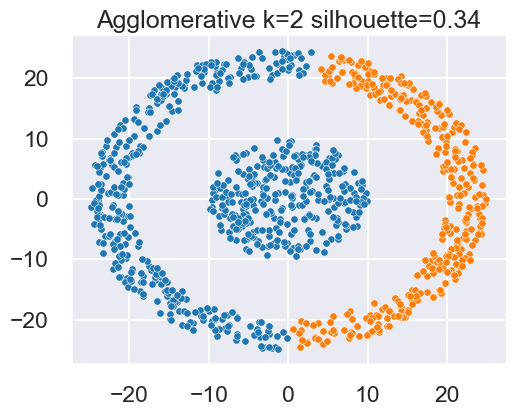

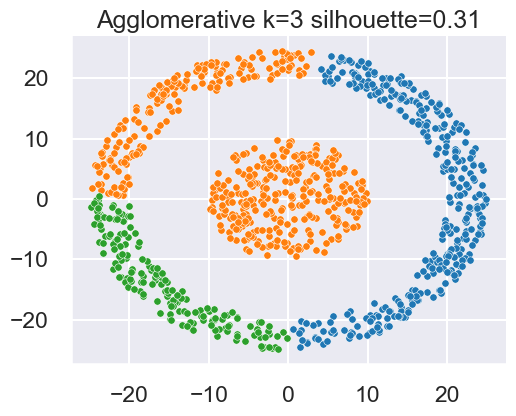

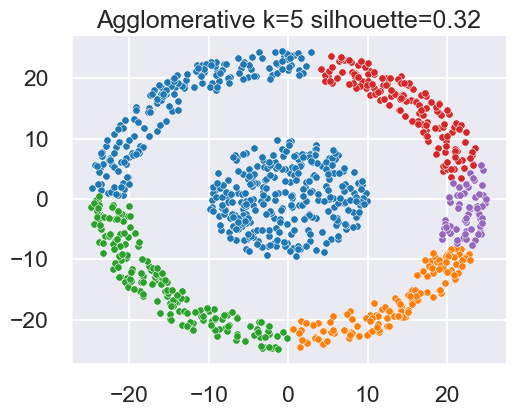

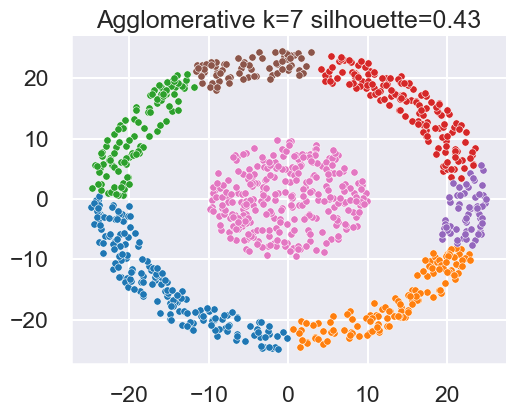

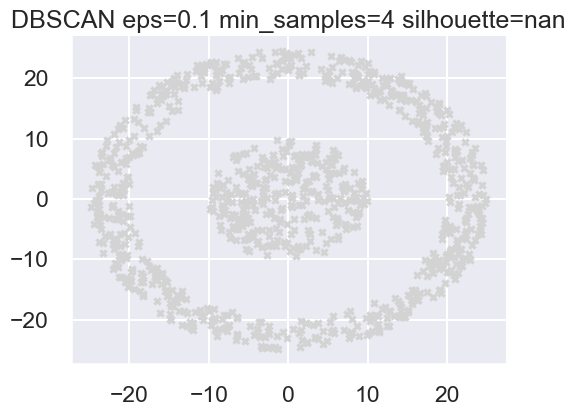

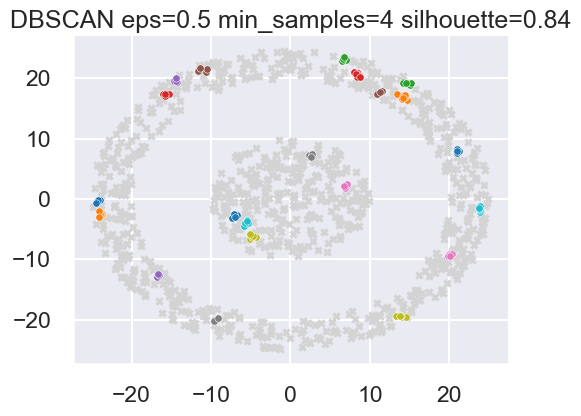

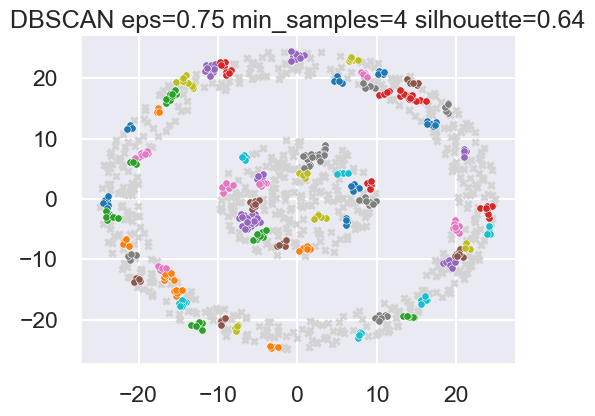

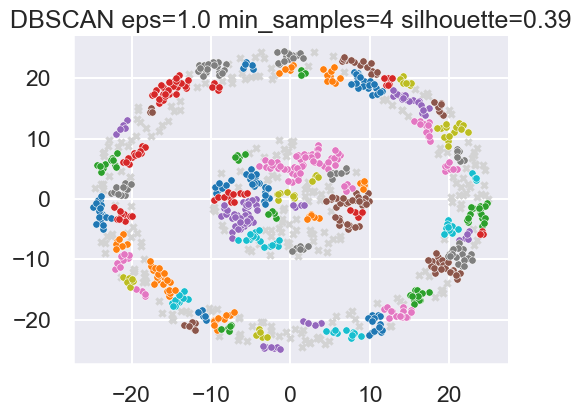

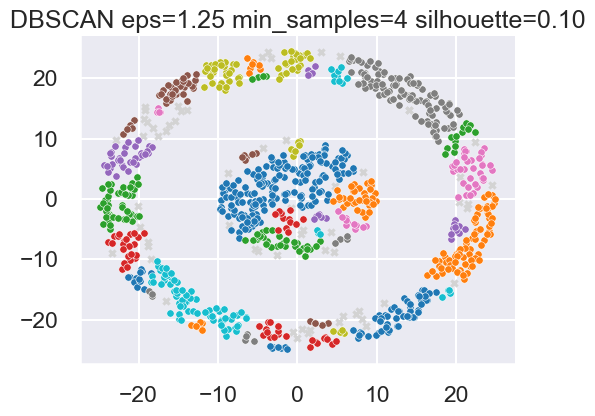

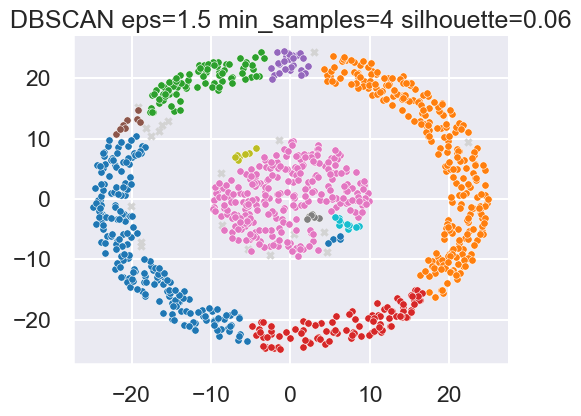

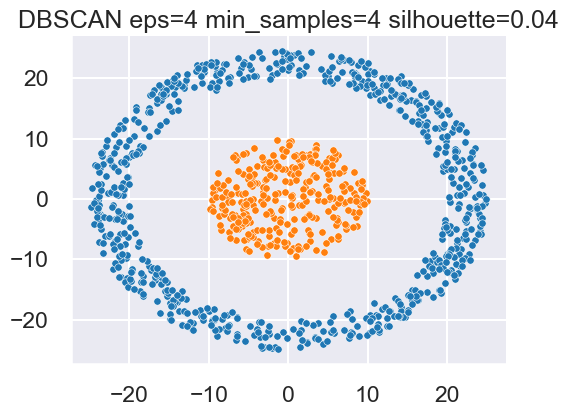

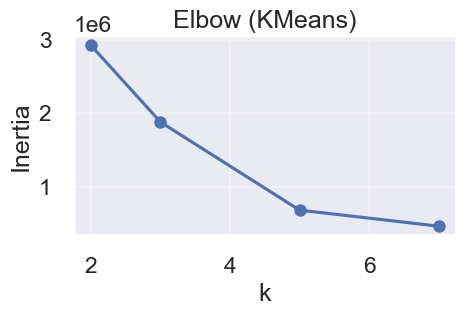

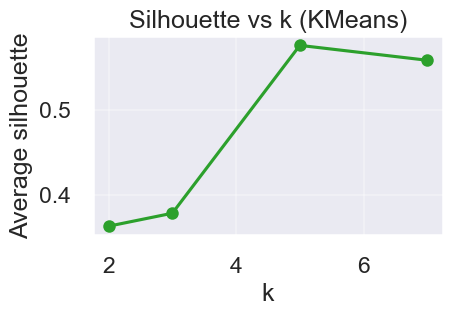

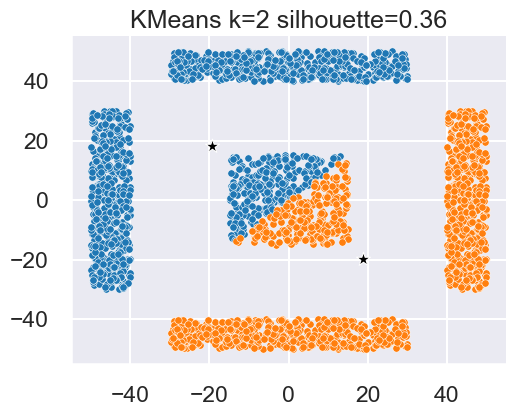

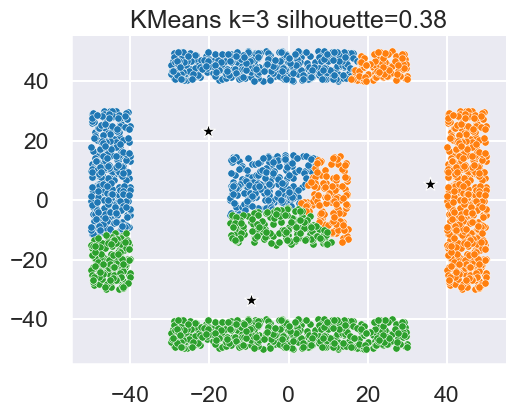

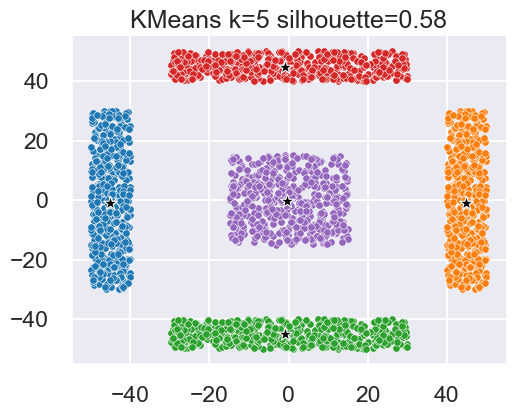

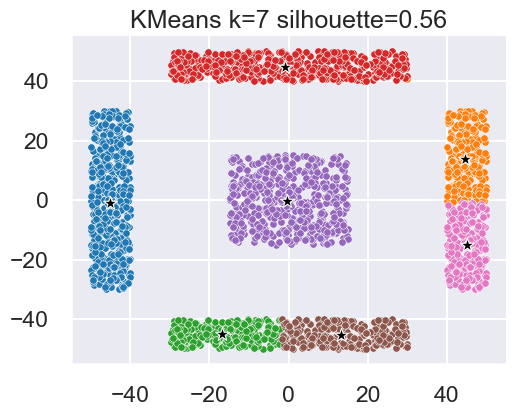

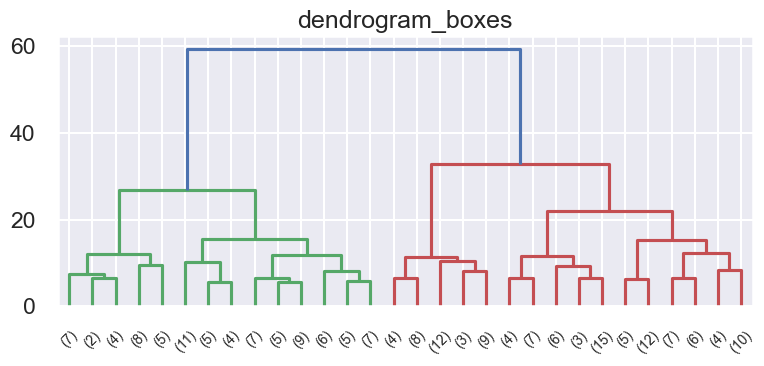

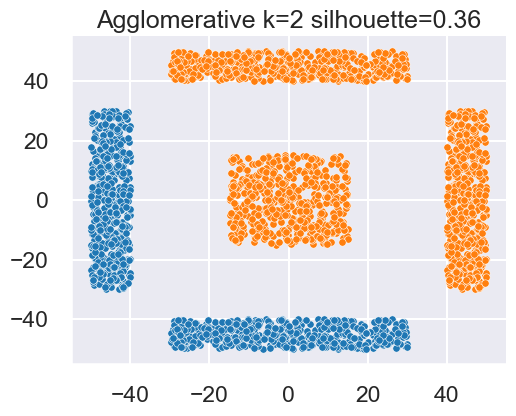

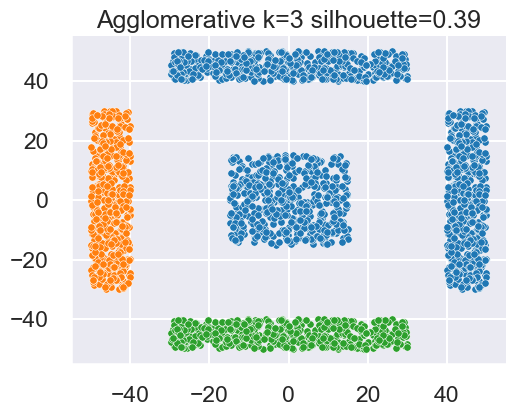

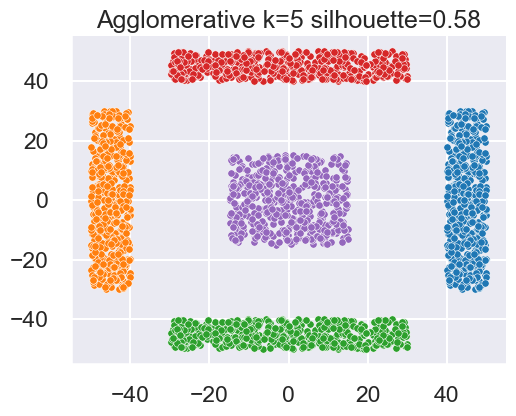

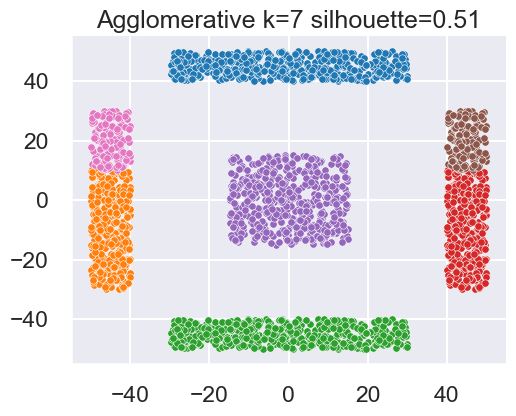

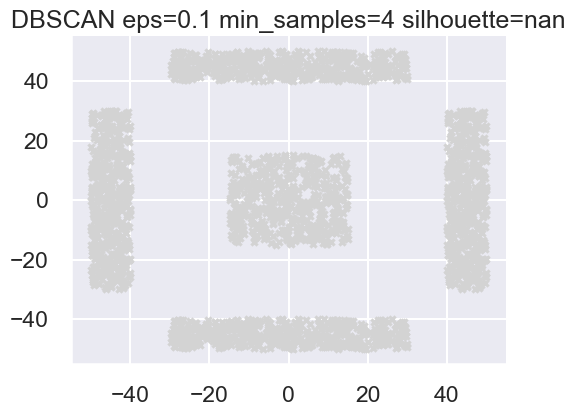

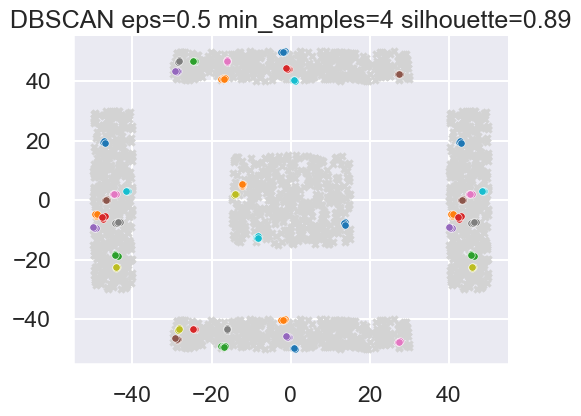

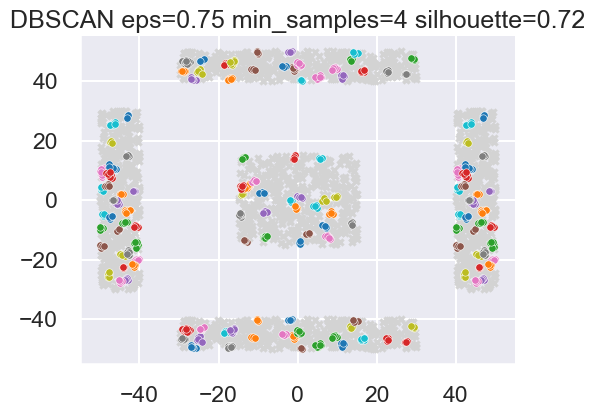

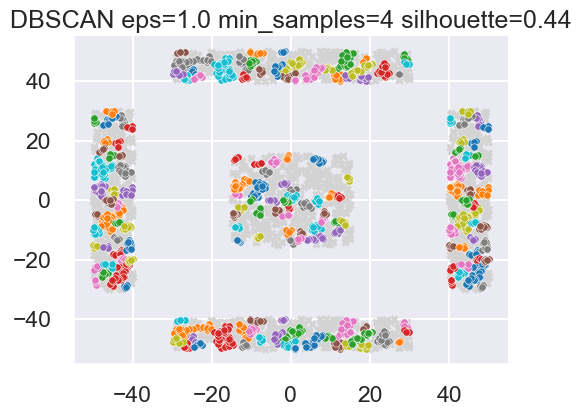

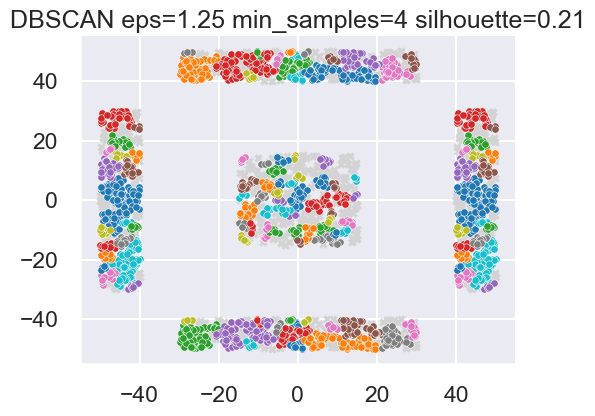

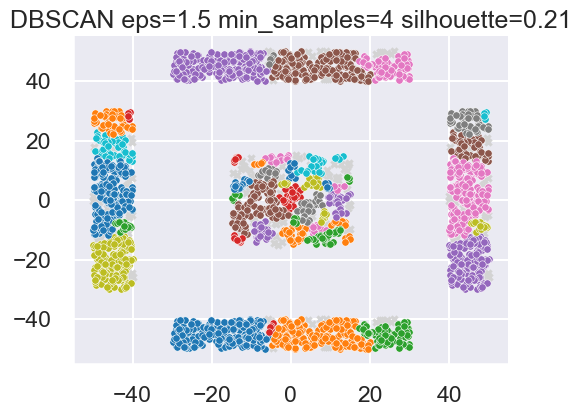

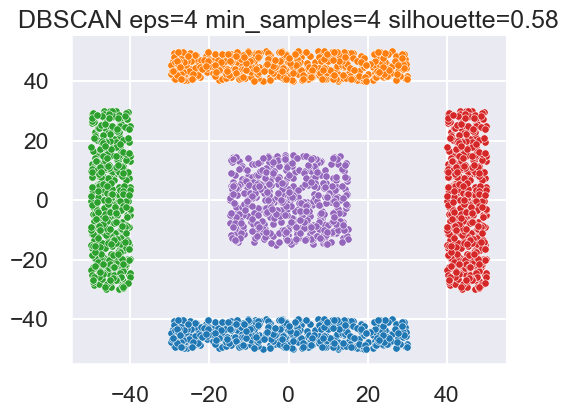

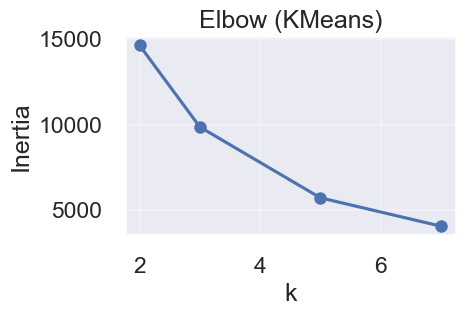

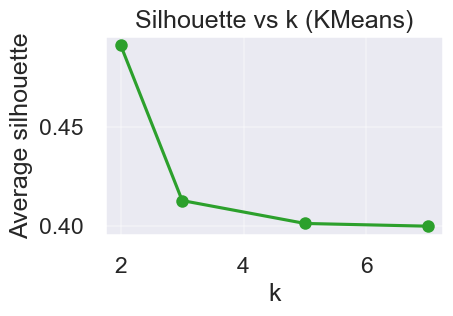

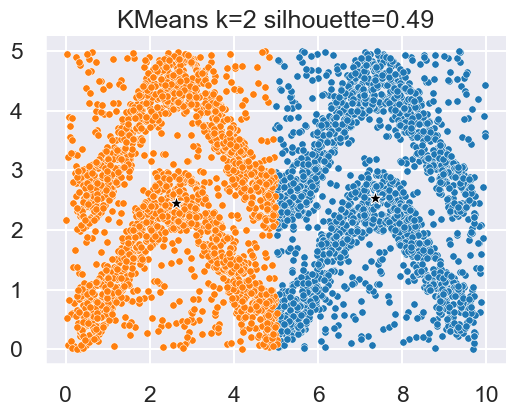

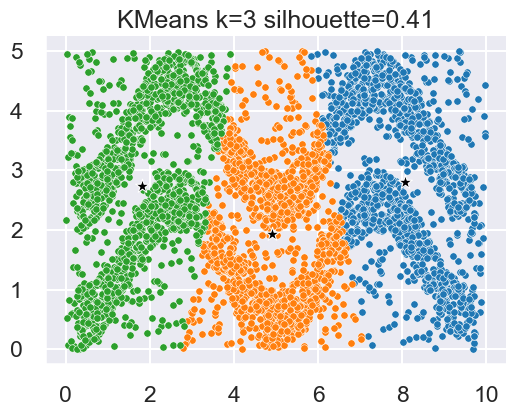

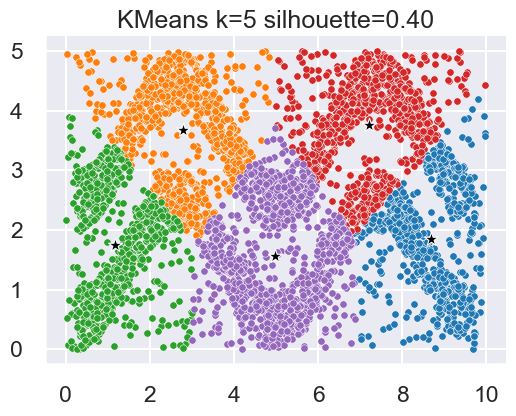

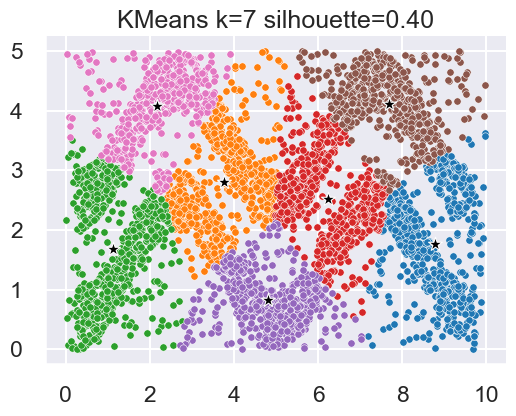

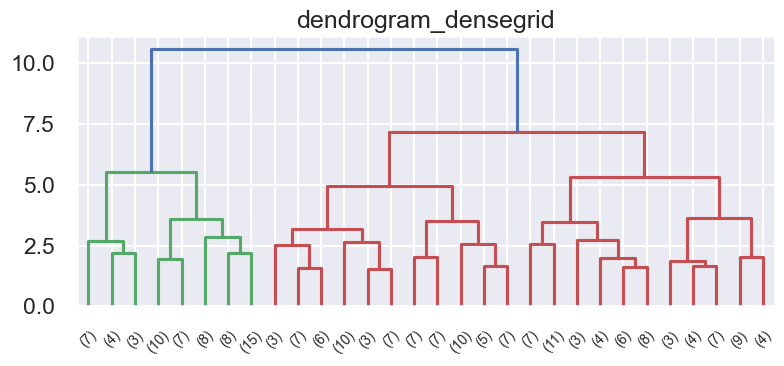

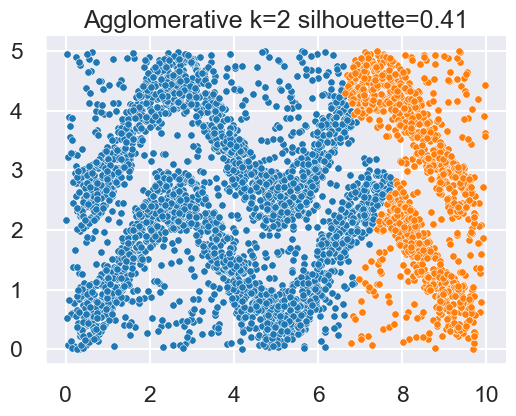

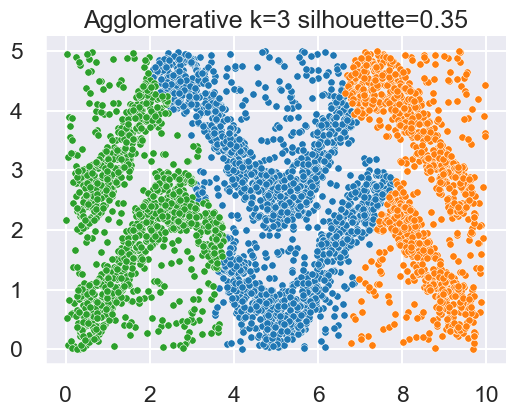

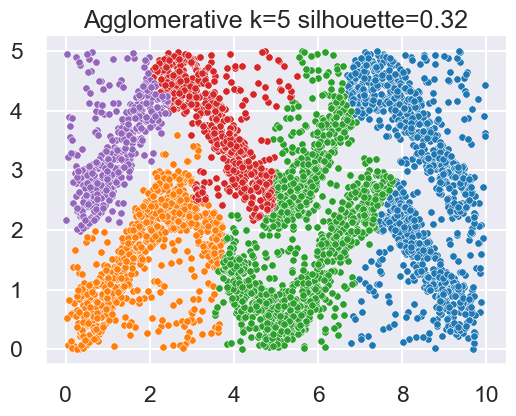

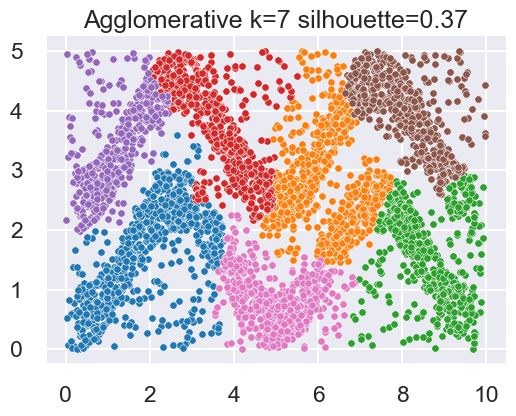

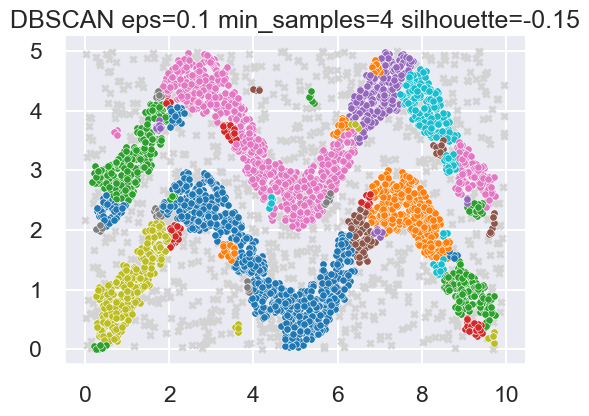

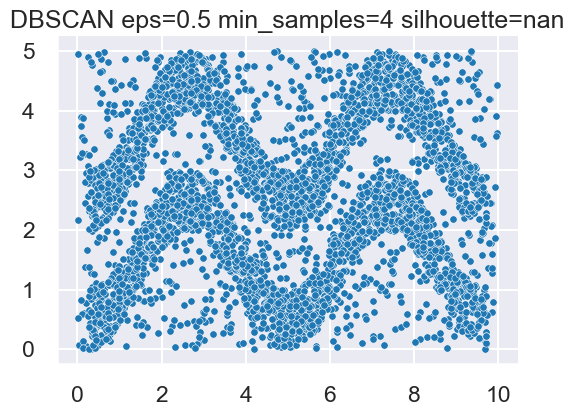

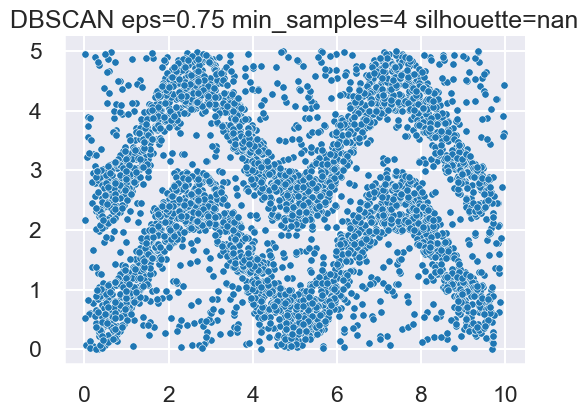

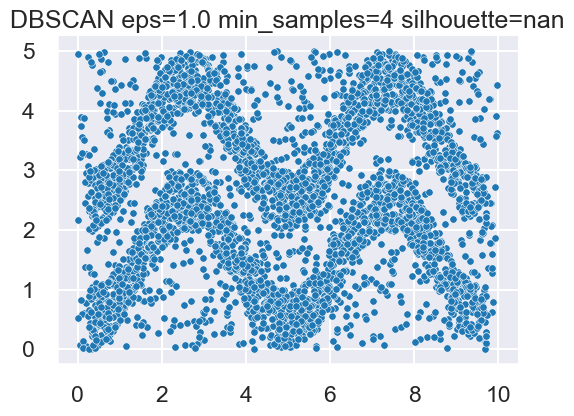

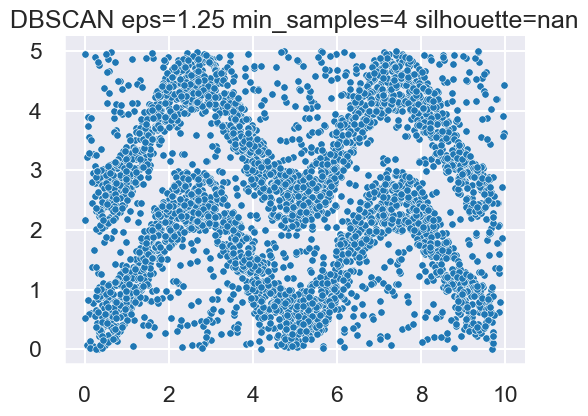

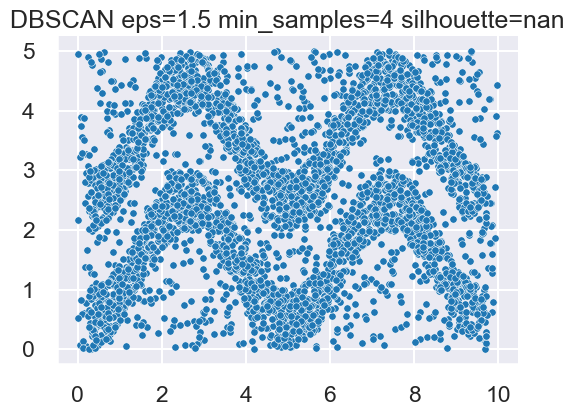

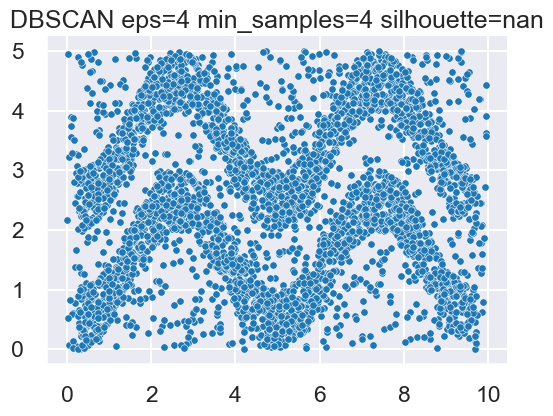

In [13]:
# # Clustering functions: KMeans, Agglomerative, DBSCAN + silhouette and dendrograms
# from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
# from sklearn.metrics import silhouette_score
# from scipy.cluster.hierarchy import linkage, dendrogram
# import matplotlib.pyplot as plt

# Improved color palette
PALETTE = sns.color_palette('tab10')

plt.style.use('seaborn-v0_8')
sns.set_context('talk')


def plot_clusters(X, labels, title, centroids=None):
    plt.figure(figsize=(5.5,4.5))
    unique = sorted(set(labels))
    # Handle noise label -1 separately
    for lab in unique:
        mask = labels == lab
        if lab == -1:
            plt.scatter(X[mask,0], X[mask,1], c='lightgray', s=20, marker='x', label='noise')
        else:
            color = PALETTE[lab % len(PALETTE)]
            plt.scatter(X[mask,0], X[mask,1], c=[color], s=28, edgecolors='white', linewidths=0.4, label=f'c{lab}')
    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c='black', s=110, marker='*', edgecolors='white', linewidths=0.8, label='centroid')
    plt.title(title)
    sns.despine()
    plt.tight_layout()


def try_kmeans(X, ks=[3,5]):
    for k in ks:
        km = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = km.labels_
        centroids = km.cluster_centers_
        s = silhouette_score(X, labels) if len(set(labels))>1 else float('nan')
        plot_clusters(X, labels, f'KMeans k={k} silhouette={s:.2f}', centroids=centroids)


def try_agglomerative(X, ks=[3,5]):
    for k in ks:
        ac = AgglomerativeClustering(n_clusters=k, linkage = 'complete').fit(X)
        labels = ac.labels_
        s = silhouette_score(X, labels) if len(set(labels))>1 else float('nan')
        plot_clusters(X, labels, f'Agglomerative k={k} silhouette={s:.2f}')


def try_dbscan(X, eps_list=[0.05,0.1,0.2,0.5], min_samples=5):
    for eps in eps_list:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        labels = db.labels_
        # silhouette only on non-noise clusters
        if (labels != -1).sum() > 1 and len(set(labels[labels!=-1]))>1:
            mask = labels != -1
            s = silhouette_score(X[mask], labels[mask])
        else:
            s = float('nan')
        plot_clusters(X, labels, f'DBSCAN eps={eps} min_samples={min_samples} silhouette={s:.2f}')


def plot_dendrogram(X, title='dendrogram', sample=200):
    n = min(len(X), sample)
    Z = linkage(X[:n], method='complete')
    plt.figure(figsize=(8,4))
    dendrogram(Z, truncate_mode='lastp', p=30)
    plt.title(title)
    plt.tight_layout()


def plot_elbow_kmeans(X, ks):
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=0).fit(X)
        inertias.append(km.inertia_)
    plt.figure(figsize=(5,3.5))
    plt.plot(ks, inertias, marker='o')
    plt.xlabel('k')
    plt.ylabel('Inertia')
    plt.title('Elbow (KMeans)')
    plt.grid(alpha=0.3)
    plt.tight_layout()


def plot_silhouette_scores(X, ks):
    scores = []
    for k in ks:
        if k < 2:
            scores.append(float('nan'))
            continue
        km = KMeans(n_clusters=k, random_state=0).fit(X)
        labels = km.labels_
        if len(set(labels)) > 1:
            scores.append(silhouette_score(X, labels))
        else:
            scores.append(float('nan'))
    plt.figure(figsize=(5,3.5))
    plt.plot(ks, scores, marker='o', color='tab:green')
    plt.xlabel('k')
    plt.ylabel('Average silhouette')
    plt.title('Silhouette vs k (KMeans)')
    plt.grid(alpha=0.3)
    plt.tight_layout()

# Run clustering on all loaded datasets
for name, X in datasets.items():
    print('===', name, '===')
    if '3' in name:
        ks=[2,3,4]
    elif '5' in name:
        ks=[3,5,7]
    else:
        ks=[2,3,5,7]
    # Summary charts first
    plot_elbow_kmeans(X, ks)
    plot_silhouette_scores(X, ks)
    # Detailed cluster visuals
    try_kmeans(X, ks=[k for k in ks if k>=2])
    plot_dendrogram(X, title=f'dendrogram_{name}')
    try_agglomerative(X, ks=[k for k in ks if k in (2,3,5,7)])
    try_dbscan(X, eps_list=[0.1, 0.5, 0.75, 1.0, 1.25, 1.5, 4], min_samples=4)
plt.show()